In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## 使用Vertex AI特征存储在线提取和服务BigQuery数据的在线功能


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/feature_store/online_feature_serving_and_fetching_bigquery_data_with_feature_store.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> 在Colab上运行
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/feature_store/online_feature_serving_and_fetching_bigquery_data_with_feature_store.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      在GitHub上查看
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/feature_store/online_feature_serving_and_fetching_bigquery_data_with_feature_store.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      在Vertex AI Workbench中打开
    </a>
  </td>                                                                                               
</table>

## 概述

本教程演示了如何在BigQuery中使用Vertex AI Feature Store进行在线服务和获取特征值。

了解有关[Vertex AI Feature Store](https://cloud.google.com/vertex-ai/docs/featurestore/overview)的更多信息。

### 目标

在本教程中，您将学习如何使用在线特征存储实例在 BigQuery 中托管和提供数据，并使用 Vertex AI Feature Store 在功能值提供和提取用户旅程的端到端工作流程中。

本教程使用以下 Google Cloud ML 服务和资源：

- Vertex AI Feature Store

执行的步骤包括：

- 配置在线特征存储实例以托管和提供数据。
- 将一个 BigQuery 视图注册到在线特征存储实例，并设置同步作业。
- 使用在线服务器提取在线预测的功能值。

数据集

本教程使用BigQuery公共数据集中的[theLook_eCommerce](https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce)数据集。

The Look eCommerce为他们的商品开发了销售预测模型。该模型使用以下数据：

* 产品名称
* 类别
* 品牌
* 成本
* 零售价
* 过去30天的订单数量，根据状态分类为好或坏。

成本

本教程使用了 Google Cloud 的计费组件：

* Vertex AI
* BigQuery

了解 [Vertex AI 价格](https://cloud.google.com/vertex-ai/pricing) 和
[BigQuery 价格](https://cloud.google.com/bigquery/pricing)
并使用 [定价计算器](https://cloud.google.com/products/calculator/)
根据您预计的使用量生成成本估算。

## 安装

安装以下所需的包以执行该笔记本。

In [ ]:
# Install the packages
! pip3 install --upgrade --quiet google-cloud-aiplatform\
                                 google-cloud-bigquery\
                                 db-dtypes

### 仅限 Colab 使用：取消注释以下单元格以重新启动内核。

In [ ]:
# # Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## 在开始之前

### 设置您的Google Cloud项目

**无论您的笔记本环境如何，以下步骤都是必需的。** 

1. [选择或创建一个Google Cloud项目](https://console.cloud.google.com/cloud-resource-manager)。当您首次创建帐户时，您将获得$300的免费信用，可用于计算/存储成本。

2. [确保为您的项目启用了计费](https://cloud.google.com/billing/docs/how-to/modify-project)。

3. [启用Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com)。

4. 如果您在本地运行此笔记本，则需要安装[Cloud SDK](https://cloud.google.com/sdk)。

设置您的项目ID

**如果您不知道您的项目ID**，请尝试以下操作：
* 运行 `gcloud config list`。
* 运行 `gcloud projects list`。
* 查看支持页面：[定位项目ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

区域

您还可以更改 Vertex AI 使用的 `REGION` 变量。了解有关[Vertex AI 区域](https://cloud.google.com/vertex-ai/docs/general/locations)的更多信息。请注意，新的 API 目前仅在以下区域可用：
* `us-centra1`
* `us-east1`
* `us-east4`
* `us-west1`
* `us-west2`
* `us-west3`
* `europe-west2`
* `europe-west3`
* `europe-west4`
* `europe-west8`
* `asia-southeast1`
* `asia-northeast2`

In [ ]:
REGION = "us-east1"  # @param {type: "string"}

### 验证您的Google Cloud账户

根据您的Jupyter环境，您可能需要手动验证。请按照以下相关说明操作。

1. 顶点 AI 工作台
* 由于您已经经过身份验证，因此无需进行任何操作。

2. 本地JupyterLab实例，取消注释并运行:

In [ ]:
# ! gcloud auth login

3. 合作，取消注释并运行：

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

4. 服务账户或其他
* 查看如何在https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples上向您的服务账户授予云存储权限。

### 导入库

In [ ]:
from google.cloud import aiplatform, bigquery
from google.cloud.aiplatform_v1 import (FeatureOnlineStoreAdminServiceClient,
                                        FeatureOnlineStoreServiceClient,
                                        FeatureRegistryServiceClient)
from google.cloud.aiplatform_v1.types import feature as feature_pb2
from google.cloud.aiplatform_v1.types import feature_group as feature_group_pb2
from google.cloud.aiplatform_v1.types import \
    feature_online_store as feature_online_store_pb2
from google.cloud.aiplatform_v1.types import \
    feature_online_store_admin_service as \
    feature_online_store_admin_service_pb2
from google.cloud.aiplatform_v1.types import \
    feature_online_store_service as feature_online_store_service_pb2
from google.cloud.aiplatform_v1.types import \
    feature_registry_service as feature_registry_service_pb2
from google.cloud.aiplatform_v1.types import feature_view as feature_view_pb2
from google.cloud.aiplatform_v1.types import \
    featurestore_service as featurestore_service_pb2
from google.cloud.aiplatform_v1.types import io as io_pb2

### 初始化用于 Python 的 Vertex AI SDK

为您的项目初始化用于 Python 的 Vertex AI SDK。

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION)

API_ENDPOINT = f"{REGION}-aiplatform.googleapis.com"

将特征数据设置在BigQuery中

在本教程中，您希望每天重新计算和更新这些数据，以提供实时预测，使在线预测应用程序始终使用最新数据。

获取当前时间的订单数量，并将检索到数据与`bigquery-public-data.thelook_ecommerce.products`表进行连接。

In [ ]:
feature_extract_query = """
WITH
 product_order_agg AS (
   SELECT cast(product_id as string) as entity_id,
     countif(status in ("Shipped", "Complete")) as good_order_count,
     countif(status in ("Returned", "Cancelled")) as bad_order_count
   FROM `bigquery-public-data.thelook_ecommerce.order_items`
   WHERE
     timestamp_trunc(created_at, day) >= timestamp_trunc(timestamp_sub(CURRENT_TIMESTAMP(), interval 30 day), day) and
     timestamp_trunc(created_at, day) < timestamp_trunc(CURRENT_TIMESTAMP(), day)
   group by 1
   order by entity_id),
 product_basic AS (
   SELECT cast(id as string) AS entity_id,
     lower(name) as name,
     lower(category) as category,
     lower(brand) as brand,
     cost,
     retail_price
   FROM   bigquery-public-data.thelook_ecommerce.products)
SELECT *, current_timestamp() as feature_timestamp
FROM product_basic
LEFT OUTER JOIN product_order_agg
USING (entity_id)
"""

查看检索到的数据

In [ ]:
bq_client = bigquery.Client(project=PROJECT_ID)

product_data = bq_client.query(feature_extract_query).result().to_dataframe()

print(product_data.shape)
product_data.head()

现在数据已经与BigQuery表连接，您可以开始设置在线服务。您有两个选项：

* 将数据实例化到专用表中。
* 创建一个每次查询都会重新生成的BigQuery视图。

本教程演示了后一种选项，即如何创建一个每次查询都会重新生成的BigQuery视图。

创建BigQuery数据集

创建一个BigQuery数据集来保存演示中的BigQuery视图。由于这个演示的源数据位于`US`地区，因此数据集也必须位于`US`地区。如果您使用自己的数据和数据集，您也可以使用该数据集来创建BigQuery视图。

In [ ]:
# First, create a dataset if it does not already exist. The source data for this demo is located in the US region, so the dataset must also be located in the US region.

BQ_DATASET_ID = "featurestore_demo"  # @param {type:"string"}
dataset = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET_ID}")
dataset.location = "US"
dataset = bq_client.create_dataset(
    dataset, exists_ok=True, timeout=30
)  # Make an API request.
# Confirm dataset created.
print(f"Created dataset {dataset}.{BQ_DATASET_ID}")

#### 创建一个BigQuery视图

In [ ]:
# Now, create the view

BQ_VIEW_ID = "product_features"  # @param {type:"string"}
BQ_VIEW_ID_FQN = f"{PROJECT_ID}.{BQ_DATASET_ID}.{BQ_VIEW_ID}"
view = bigquery.Table(BQ_VIEW_ID_FQN)
view.view_query = feature_extract_query
view = bq_client.create_table(view, exists_ok=True)

print(f"Created {view.table_type}: {str(view.reference)}")

## 设置和启动在线服务

现在是令人兴奋的部分！要在特征存储中提供数据，您需要执行以下操作：

1. 创建一个在线存储集群来托管数据。
    * 使用自动调整功能创建一个“FeatureOnlineStore”实例。
1. 定义要由新创建实例提供的数据（“FeatureView”）。这可以映射到以下之一：
    * 您刚创建用于提供数据的 BigQuery 视图。
    * 我们将用于托管特征元数据的“FeatureGroup”和“Feature”。

Bigtable 服务的延迟受（Bigtable）负载的影响。然而，当 Bigtable 没有过载时，基准测试显示，预期的服务器端延迟大约为 30 毫秒，以大约 100 qps 测量。客户端端延迟预计比服务器端延迟高出 5 毫秒以上。

初始化Admin服务客户端

In [ ]:
admin_client = FeatureOnlineStoreAdminServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)
registry_client = FeatureRegistryServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

创建在线商店实例

要创建一个在线商店实例。
创建一个带有自动扩展功能的`FeatureOnlineStore`实例。

In [ ]:
FEATURE_ONLINE_STORE_ID = "the_look_demo_unique"  # @param {type:"string"}

online_store_config = feature_online_store_pb2.FeatureOnlineStore(
    bigtable=feature_online_store_pb2.FeatureOnlineStore.Bigtable(
        auto_scaling=feature_online_store_pb2.FeatureOnlineStore.Bigtable.AutoScaling(
            min_node_count=1, max_node_count=3, cpu_utilization_target=50
        )
    )
)

create_store_lro = admin_client.create_feature_online_store(
    feature_online_store_admin_service_pb2.CreateFeatureOnlineStoreRequest(
        parent=f"projects/{PROJECT_ID}/locations/{REGION}",
        feature_online_store_id=FEATURE_ONLINE_STORE_ID,
        feature_online_store=online_store_config,
    )
)

### 验证在线商店实例创建

长时间运行的操作（LRO）完成后，显示结果。

> **注意：** 此操作可能需要最多10分钟才能完成。

In [ ]:
# Wait for the LRO to finish and get the LRO result.
print(create_store_lro.result())

验证`FeatureOnlineStore`实例是否已创建，方法是列出该地区的所有在线商店。

In [ ]:
# Use list to verify the store is created.
admin_client.list_feature_online_stores(
    parent=f"projects/{PROJECT_ID}/locations/{REGION}"
)

### 创建特征视图实例

创建`FeatureOnlineStore`实例后，您可以定义要提供的特征。为此，请创建`FeatureView`实例，该实例指定以下内容：

* 与`FeatureOnlineStore`实例同步提供服务的数据源（BigQuery表或视图URI或FeatureGroup/特征）。
* 运行同步管道的计划任务时间表。

选项1：直接使用BQ数据源创建featureView

##### Data source preparation guidelines for BigQuery data source

If the feature data for online serving is not already available in a BigQuery table or view, you can create a BigQuery dataset and table, and then load the data into it.

Note that if you choose to use BigQuery source, Feature Store only provides the option to snapshot and sync the entire BigQuery table or view for online serving. You need to construct this table or view to reflect the latest data to be served. Therefore, a timestamp column is not needed, since timestamps aren't used to differentiate the feature values.

Use the following guidelines to understand the schema and constraints while creating the BigQuery source:

* The BigQuery table or view *must* have a column with `string` values to use as the (entity) IDs. You'll need to specify that this column is the ID column during `FeatureView` creation. Note that the size of each value in this column must be less than 4 KB.
* Feature Store ignores rows containing the duplicate values in the ID column and arbitrarily picks one to use for online serving. This might occur if the table or view has multiple feature values recorded at different timestamps. In this case, you need to sync the data in your table based on the latest timestamp before serving.
* Feature Store considers each row as a complete record. For example, if a feature value is missing in one of the columns, then it's considered as a null value.
* Provide values for each feature is a separate column. Supported data types are `bool`, `int`, `double`, `string`, timestamp, arrays of these data types, and bytes. Note that the timestamp data type is converted to `int64` during data sync.
* Feature Store validates the schema during `FeatureView` creation. However, it doesn't revalidate the schema during each data sync. Columns with unsupported data types added after `FeatureView` creation time are ignored.
* The BigQuery table or view must be in either the same region as the online store, or in a multiregion that overlaps with the online store. For example, if the online store is in `us-central`, the BigQuery source can be in `us-central` or in `US`.

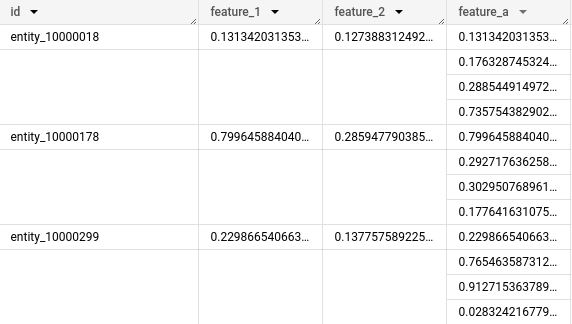


In [ ]:
FEATURE_VIEW_ID = "product"  # @param {type:"string"}
CRON_SCHEDULE = "TZ=America/Los_Angeles 56 * * * *"  # @param {type:"string"}

big_query_source = feature_view_pb2.FeatureView.BigQuerySource(
    uri=f"bq://{BQ_VIEW_ID_FQN}", entity_id_columns=["entity_id"]
)

sync_config = feature_view_pb2.FeatureView.SyncConfig(cron=CRON_SCHEDULE)

create_view_lro = admin_client.create_feature_view(
    feature_online_store_admin_service_pb2.CreateFeatureViewRequest(
        parent=f"projects/{PROJECT_ID}/locations/{REGION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}",
        feature_view_id=FEATURE_VIEW_ID,
        feature_view=feature_view_pb2.FeatureView(
            big_query_source=big_query_source,
            sync_config=sync_config,
        ),
    )
)

# Wait for LRO to complete and show result
print(create_view_lro.result())

#### 选项2：使用FeatureGroups/Feature创建featureView

> **注意：** 如果您已经使用BQ数据源创建了一个feature view，请跳过本节，前往[验证在线商店实例创建](#scrollTo=igOmzHxx1C0X)。

[可选] 创建功能组/功能

为演示创建指向已创建的BigQuery视图的FeatureGroup。然后我们将为我们想要注册的每一列创建功能。

##### 用于特征注册数据源的数据源准备指南

请注意，如果您选择使用特征注册源，则特征存储仅提供支持时间序列源的选项，特征存储将为其生成最新的特征值。

请使用以下指南了解在创建BigQuery源时的模式和约束：

* BigQuery表或视图*必须*具有一个包含`string`值的列，以用作（实体）ID。在`FeatureGroup`创建期间，您需要指定此列为ID列。请注意，该列中每个值的大小必须小于4 KB。
* BigQuery表或视图*必须*具有名为`feature_timestamp`的列，其中包含`timestamp`值，以用作时间戳列。
* 特征注册源默认视为稀疏的，即时间点查找（BQ.ML_FEATURES_AT_TIME()）会为每个实体ID生成最新的特征值。
* 为每个特征提供值是单独的列。支持的数据类型包括`bool`、`int`、`double`、`string`、timestamp、这些数据类型的数组和字节。请注意，在数据同步期间，时间戳数据类型将转换为`int64`。
* 特征存储在`FeatureView`/`FeatureGroup`/`Featre`创建期间验证模式。但是，在每次数据同步期间，它不会重新验证模式。在`FeatureView`创建时间后添加的不受支持数据类型列将被忽略。
* BigQuery表或视图必须位于与在线存储相同的区域中，或位于与在线存储重叠的多区域中。例如，如果在线存储位于`us-central`，则BigQuery源可以位于`us-central`或`US`。

In [ ]:
FEATURE_GROUP_ID = "product_features_unique"  # @param {type: "string"}
FEATURE_IDS = [
    "good_order_count",
    "bad_order_count",
    "category",
    "name",
    "brand",
    "cost",
    "retail_price",
]  # @param

In [ ]:
# Now, create the featureGroup

feature_group_config = feature_group_pb2.FeatureGroup(
    big_query=feature_group_pb2.FeatureGroup.BigQuery(
        big_query_source=io_pb2.BigQuerySource(input_uri=f"bq://{BQ_VIEW_ID_FQN}")
    )
)

create_group_lro = registry_client.create_feature_group(
    feature_registry_service_pb2.CreateFeatureGroupRequest(
        parent=f"projects/{PROJECT_ID}/locations/{REGION}",
        feature_group_id=FEATURE_GROUP_ID,
        feature_group=feature_group_config,
    )
)

长时间运行操作（LRO）完成后，显示结果。

In [ ]:
print(create_group_lro.result())

In [ ]:
create_feature_lros = []
for id in FEATURE_IDS:
    create_feature_lros.append(
        registry_client.create_feature(
            featurestore_service_pb2.CreateFeatureRequest(
                parent=f"projects/{PROJECT_ID}/locations/{REGION}/featureGroups/{FEATURE_GROUP_ID}",
                feature_id=id,
                feature=feature_pb2.Feature(),
            )
        )
    )

In [ ]:
for lro in create_feature_lros:
    print(lro.result())

为之前在本教程中创建的BigQuery视图和FeatureGroup/features创建一个`FeatureView`实例，并将同步时间和频率设置为每天凌晨1点（PST时间）。

In [ ]:
FEATURE_VIEW_ID = "registry_product"  # @param {type:"string"}
CRON_SCHEDULE = "TZ=America/Los_Angeles 56 * * * *"  # @param {type:"string"}

feature_registry_source = feature_view_pb2.FeatureView.FeatureRegistrySource(
    feature_groups=[
        feature_view_pb2.FeatureView.FeatureRegistrySource.FeatureGroup(
            feature_group_id=FEATURE_GROUP_ID, feature_ids=FEATURE_IDS
        )
    ]
)

sync_config = feature_view_pb2.FeatureView.SyncConfig(cron=CRON_SCHEDULE)

create_view_lro = admin_client.create_feature_view(
    feature_online_store_admin_service_pb2.CreateFeatureViewRequest(
        parent=f"projects/{PROJECT_ID}/locations/{REGION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}",
        feature_view_id=FEATURE_VIEW_ID,
        feature_view=feature_view_pb2.FeatureView(
            feature_registry_source=feature_registry_source,
            sync_config=sync_config,
        ),
    )
)

# Wait for LRO to complete and show result
print(create_view_lro.result())

验证`FeatureView`实例是否已创建，方法是列出在线商店中的所有特色视图。

In [ ]:
# Again, list all feature view under the FEATURE_ONLINE_STORE_ID to confirm
admin_client.list_feature_views(
    parent=f"projects/{PROJECT_ID}/locations/{REGION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}"
)

注意
将数据同步到FeatureOnlineStores是一个公开的预览版。通过使用该功能，您承认您已了解存在的问题，并且此预览根据预先GA规定的服务条款提供“如是”。

### 手动开始同步

同步流水线根据`FeatureView`实例中指定的时间表执行。

要跳过等待并立即执行同步流水线，请手动开始同步。

In [ ]:
sync_response = admin_client.sync_feature_view(
    feature_view=f"projects/{PROJECT_ID}/locations/{REGION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

`sync_response` 包含同步作业的 ID。

使用 `get_feature_view_sync` 来检查作业的状态。

In [ ]:
import time

while True:
    feature_view_sync = admin_client.get_feature_view_sync(
        name=sync_response.feature_view_sync
    )
    if feature_view_sync.run_time.end_time.seconds > 0:
        status = "Succeed" if feature_view_sync.final_status.code == 0 else "Failed"
        print(f"Sync {status} for {feature_view_sync.name}.")
        break
    else:
        print("Sync ongoing, waiting for 30 seconds.")
    time.sleep(30)

使用`list_feature_view_syncs`查看所有同步。

In [ ]:
admin_client.list_feature_view_syncs(
    parent=f"projects/{PROJECT_ID}/locations/{REGION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

###开始在线服务

数据同步完成后，使用`FetchFeatureValues` API来检索数据。

In [ ]:
data_client = FeatureOnlineStoreServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

`FeatureView` 已经定义了模型所需的特征（通过此演示中的 BigQuery 视图）。要获取数据，请提交一个 `fetch_feature_values` 请求，指定 `FeatureView` 资源路径和实体的 ID。

In [ ]:
data_client.fetch_feature_values(
    request=feature_online_store_service_pb2.FetchFeatureValuesRequest(
        feature_view=f"projects/{PROJECT_ID}/locations/{REGION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}",
        data_key=feature_online_store_service_pb2.FeatureViewDataKey(key="28098"),
    )
)

您可以使用 `FetchFeatureValuesRequest.Format` 来指定响应格式。如果您不指定格式，那么默认的格式将被设置为 `KEY_VALUE`。`PROTO_STRUCT` 是另一种支持的格式。

In [ ]:
data_client.fetch_feature_values(
    request=feature_online_store_service_pb2.FetchFeatureValuesRequest(
        feature_view=f"projects/{PROJECT_ID}/locations/{REGION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}",
        data_key=feature_online_store_service_pb2.FeatureViewDataKey(key="28098"),
        data_format=feature_online_store_service_pb2.FeatureViewDataFormat.PROTO_STRUCT,
    )
)

## 清理工作

要清理此项目中使用的所有Google Cloud资源，您可以删除用于本教程的[Google Cloud 项目](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects)。

否则，您可以删除本教程中创建的各个资源。

In [ ]:
# Delete Features
for id in FEATURE_IDS:
    registry_client.delete_feature(
        name=f"projects/{PROJECT_ID}/locations/{REGION}/featureGroups/{FEATURE_GROUP_ID}/features/{id}"
    )

# Delete Featuregroup
registry_client.delete_feature_group(
    name=f"projects/{PROJECT_ID}/locations/{REGION}/featureGroups/{FEATURE_GROUP_ID}"
)

# Delete FeatureViews
admin_client.delete_feature_view(
    name=f"projects/{PROJECT_ID}/locations/{REGION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

# Delete OnlineStore
admin_client.delete_feature_online_store(
    name=f"projects/{PROJECT_ID}/locations/{REGION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}",
    force=True,
)

# Delete BigQuery dataset. Uncomment and run the command below if you want to delete the BigQuery set.
# Do this only if the dataset is created for this demo.
# bq_client.delete_dataset(BQ_DATASET_ID, delete_contents=True, not_found_ok=True)